In [1]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot

import os

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
def get_extended_sleep(states, sleep_th, wake_th):

    # Return extended sleep session given state, sleep

    ext_sleep = states['sws'].union(
        states['Rem']).merge_close_intervals(wake_th, time_units='s')
    ext_sleep = ext_sleep[ext_sleep.duration(
        time_units='s') > sleep_th].reset_index(drop=True)

    return ext_sleep

In [3]:
def main(base_folder, local_path, *args, **kwargs):
    # state = args[0]
    bk.load.current_session_linux(base_folder, local_path)
    channels = {
        'hpc':bk.load.ripple_channel(),
        'bla':bk.load.random_channel('BLA')
    }

    states = bk.load.states()
    extsleep = get_extended_sleep(states, 60*30, 60)
    # extwake = get_extended_wake(states, 60*30, 60)

    coherences = []
    for s, e in extsleep.iloc:
        current_sleep = nts.IntervalSet(s, e)

        intervals = {
            'first': states['Rem'].intersect(current_sleep)[0:1],
            'last': states['Rem'].intersect(current_sleep)[-1:]
        }

        coherence = {}
        for n,inter in intervals.items():
            lfps = {
                'hpc':bk.load.lfp_in_intervals(channels['hpc'], inter),
                'bla':bk.load.lfp_in_intervals(channels['bla'], inter)
            }
            f, Cxy = scipy.signal.coherence(lfps['hpc'], lfps['bla'],nperseg=5000,noverlap=2500,fs = 1250)
            coherence.update({n:Cxy})
        coherences.append(coherence)

    return  f, coherences

In [4]:
def merge_coherences(batch):
    merged = []
    for n,b in batch.items():
        for i in b[1]:
            merged.append(i)
        f = b[0]
    df = pd.DataFrame(merged)
    print(len(df))
    mean = {
        'first':np.mean(df['first']),
        'last':np.mean(df['last'])
    }

    std = {
        'first':np.std(df['first'].values),
        'last':np.std(df['last'].values)
    }

    return mean,std,f

In [5]:
def plot_coherences(mean,std,f):
    for inter in mean:
        plt.fill_between(f,mean[inter] - std[inter],mean[inter] + std[inter],alpha = 0.2)
        plt.plot(f,mean[inter])


    plt.title('Coherence Ext Sleep')
    plt.legend(['First','Last'])

    plt.ylabel('Cxy')
    plt.xlabel('Freq (Hz)')
    plt.xlim(0,80)

In [6]:
batch = bk.load.batch(main)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/electrophy/Gabrielle/GG-Dataset'

25


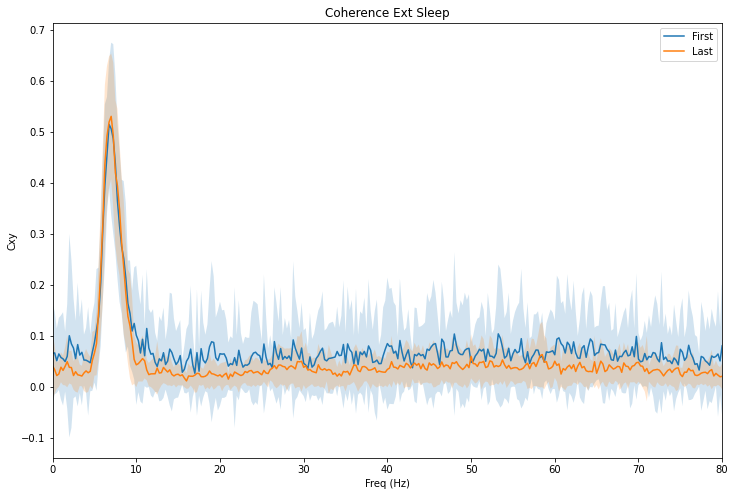

In [12]:
mean,std,f = merge_coherences(batch)
plt.figure(figsize=(12,8))
plot_coherences(mean,std,f)
plt.savefig('/home/billel/pCloudDrive/IFM/work/Figures_Gabrielle/coherence_across_sleep/coherence_ext_sleep.svg')

In [3]:
a = [1,2,3]
a[0:2]

[1, 2]

In [14]:
def main(base_folder,local_path,*args,**kwargs):
    bk.load.current_session_linux(base_folder,local_path)
    
    states = bk.load.states()

    stru = ['BLA_L','BLA_R','Hpc']
    
    channels = [bk.load.bla_channels()['left'],bk.load.bla_channels()['right'],bk.load.ripple_channel()]

    if np.nan in channels[0:2]:
        return None

    lfp = {
        'Rem':{},
        'sws':{},
        'wake_homecage':{}
    }
    coherences = {}
    for i in ['Rem','sws','wake_homecage']:
        for s,c in zip(stru,channels):
            lfp[i].update({s:bk.load.lfp_in_intervals(c,states[i])})

        f,coh = scipy.signal.coherence(lfp[i]['BLA_L'],lfp[i]['BLA_R'],1250,nperseg=5000)
        coherences.update({i:coh})
    coherences.update({'f':f})
    
    fig, ax = plt.subplots(1,3,figsize = (12,8),sharex=True)
    for i,s in enumerate(['Rem','sws','wake_homecage']):
        ax[i].plot(coherences['f'],coherences[s])
        ax[i].set_xlim(0,80)
        ax[i].set_ylim(0,1)
        ax[i].set_xlabel('Freq (Hz')
        ax[i].set_ylabel('Coherence')   
        ax[i].set_title(f'{s}')
    plt.suptitle(f'Coherence BLA Right/Left {bk.load.session}')
    plt.tight_layout()

    return coherences


In [16]:
main('/home/billel/Data/GG-Dataset/','Rat08/Rat08-20130708')


Rat : 8 on day : 1
Working with session Rat08-20130708 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130708


In [17]:
bk.load.batch(main,verbose=True)

  3%|▎         | 2/61 [00:00<00:03, 15.80it/s]

Loading Data from Rat08-20130708
Rat : 8 on day : 1
Working with session Rat08-20130708 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130708
Loading Data from Rat08-20130709
Rat : 8 on day : 2
Working with session Rat08-20130709 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130709
Error in session Rat08-20130709
Loading Data from Rat08-20130710
Rat : 8 on day : 3
Working with session Rat08-20130710 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130710


  7%|▋         | 4/61 [00:00<00:04, 13.94it/s]

Error in session Rat08-20130710
Loading Data from Rat08-20130711
Rat : 8 on day : 4
Working with session Rat08-20130711 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130711
Error in session Rat08-20130711
Loading Data from Rat08-20130712
Rat : 8 on day : 5
Working with session Rat08-20130712 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130712


  8%|▊         | 5/61 [05:11<1:26:05, 92.24s/it]

Loading Data from Rat08-20130713
Rat : 8 on day : 6
Working with session Rat08-20130713 @ /home/billel/Data/GG-Dataset/Rat08/Rat08-20130713
